In [100]:
import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [23]:
searched_format = 'csv'
for file in os.listdir(os.getcwd()):
    if searched_format not in file:
        continue
    PATH = os.path.abspath(file)
    with open(PATH, 'r', encoding='cp1251') as scan_file:
        if 'segment' in scan_file.readlines()[0]:
            button_change_df = pd.read_csv(PATH)
        else:
            picture_change_df = pd.read_csv(PATH)
            

In [25]:
button_change_df.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [29]:
picture_change_df.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


## Проверим, являются ли дисперсии внутри групп датафрейма button_change_df примерно одинаковыми (гомогенными) с помощью теста Левена

In [35]:
rect_16_9_group = picture_change_df.query('group == "A"')
square_group = picture_change_df.query('group == "B"')
rect_12_4_group = picture_change_df.query('group == "C"')

In [36]:
ss.levene(rect_16_9_group.events, square_group.events, rect_12_4_group.events)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

## Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка.
### Перед применением критерия при проверке на нормальность сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты

In [50]:
ss.shapiro(rect_16_9_group.events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [48]:
ss.shapiro(square_group.events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [49]:
ss.shapiro(rect_12_4_group.events.sample(1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

### Посчитаем тест Шапиро-Уилка без использования метода sample. Сравним  результат с normaltest, а также qq-графиками. 

In [51]:
ss.shapiro(rect_16_9_group.events)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)

In [52]:
ss.normaltest(rect_16_9_group.events)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

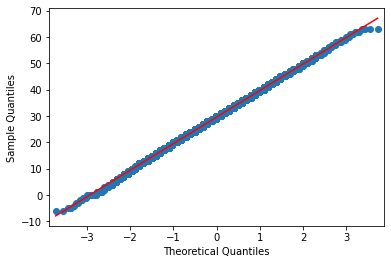

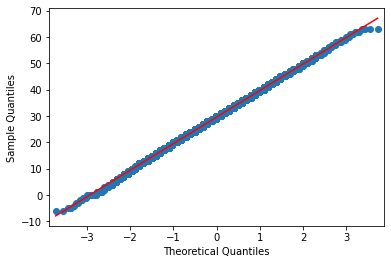

In [56]:
sm.qqplot(rect_16_9_group.events, line='r')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


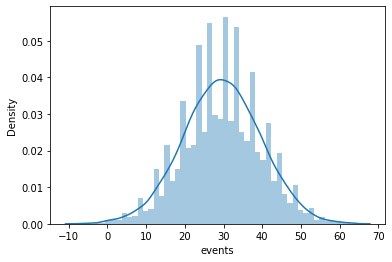

In [57]:
sns.distplot(rect_16_9_group.events)

## Проведем тест - сравнение средних, используя однофакторный диспресионный анализ (f-статистику Фишера)

In [58]:
ss.f_oneway(rect_16_9_group.events, square_group.events, rect_12_4_group.events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

## Используем критерий Тьюки и определим, между какими группами есть статистически значимые различия

In [64]:
print(pairwise_tukeyhsd(picture_change_df.events, picture_change_df.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


In [69]:
pg.pairwise_tukey(data=picture_change_df, dv="events", between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


## Визуализируем распределение events для контрольной и тестовой групп у кнопки:

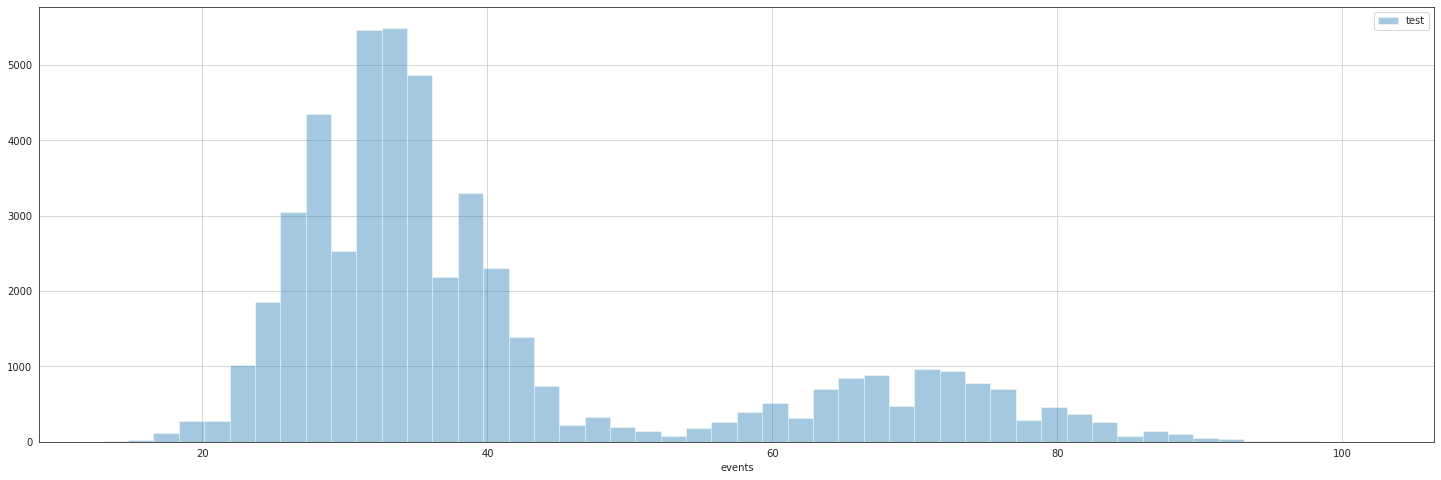

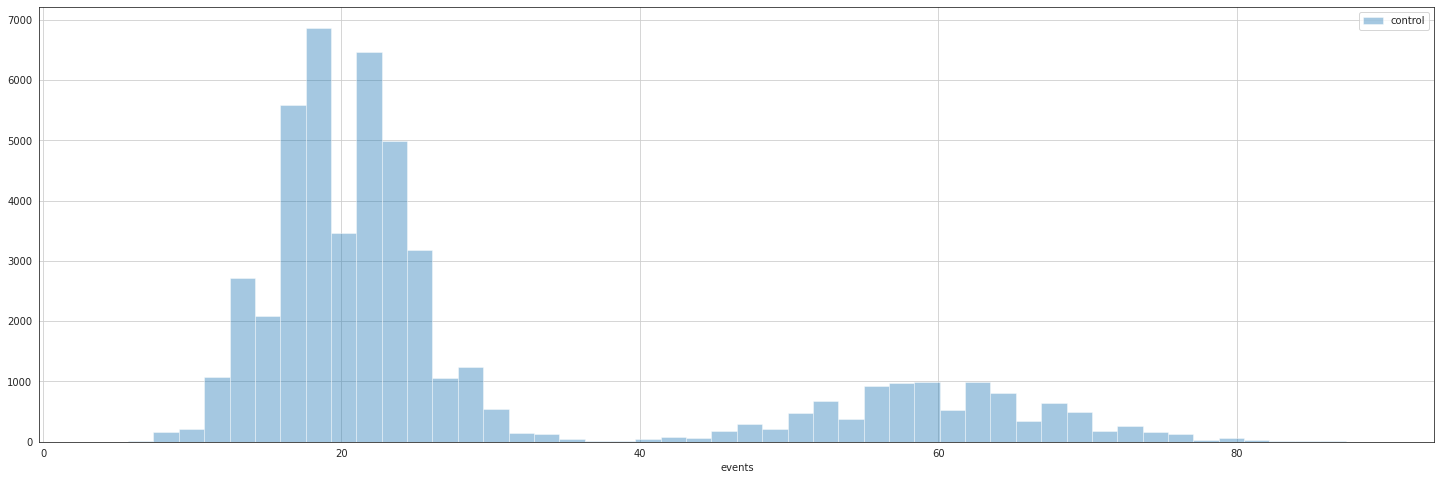

In [75]:
for group in button_change_df.group.unique():
    plt.figure(figsize = (25,8))
    sns.set_style("white")    
    sns.distplot(button_change_df.query("group == @group").events, kde=False, label=group)
    plt.legend()
    plt.grid()
plt.show()

## Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя:

In [84]:
indicators_df = button_change_df.groupby(['group', 'segment']) \
                                .agg({'events': ['mean', 'median', 'std']})
indicators_df

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

In [98]:
# стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки
high_control_std = indicators_df.query('group == "control" and segment == "high"').events['std'].sum().round(2)

In [99]:
high_control_std

7.81

## Проведем тест (через anova_lm либо pg.anova), а затем используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

### Проведем 2-х факторный дисперсионный анализ результатов эксперимента

##### Через statsmodels

In [102]:
formula = 'events ~ group + segment + group:segment'
model = ols(formula, button_change_df).fit()
aov_table = anova_lm(model, typ=2)

In [103]:
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


##### Через pengouin

In [104]:
pg.anova(data=button_change_df, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


### Установим, между какими группами присутствует статистически значимые различия с помощью критерия Тьюки:

In [106]:
button_change_df.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [131]:
button_change_df['combination'] = button_change_df['group'] + ' \\ ' + button_change_df['segment']
button_change_df

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


In [135]:
tukey_test = pairwise_tukeyhsd(button_change_df.events, button_change_df.combination).summary()
tukey_test

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


## Визуализируем результаты эксперимента

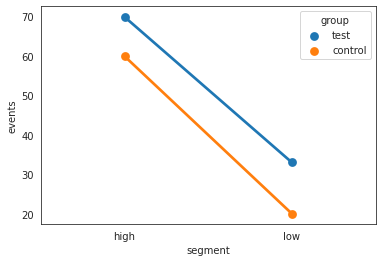

In [137]:
sns.pointplot(data=button_change_df, x='segment', y='events', hue='group')